# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# models
import statsmodels.api as sm
from statsmodels.formula.api import ols

---

# 3.27 Predicting Car Prices

Multiple regression: Multiple independent variables. Example- predicting price of car based on body style, brand, mileage, etc.

Multi**variate** regression: Multiple dependent variables (things you're trying to predict)

Based on the EDA below, summary of plan to predict price:
- ohe Make, Type
- independent vars: mileage, make, type, cylinders, doors, cruise, leather
- re doors: once ohe type, and scale the df, see correlation between doors and type. this could be multcol.
- linreg price vs mileage, make, cylinders?

In [2]:
cars = pd.read_excel('http://cdn.sundog-soft.com/Udemy/DataScience/cars.xls')
cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Model     804 non-null    object 
 4   Trim      804 non-null    object 
 5   Type      804 non-null    object 
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 75.5+ KB


In [4]:
cars.describe()

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.037313,3.527363,0.752488,0.679104,0.723881
std,9884.852801,8196.319707,1.387531,1.105562,0.850169,0.431836,0.467111,0.447355
min,8638.930895,266.000000,4.000000,1.600000,2.000000,0.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,2.200000,4.000000,1.000000,0.000000,0.000000
50%,18024.995019,20913.500000,6.000000,2.800000,4.000000,1.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,3.800000,4.000000,1.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,6.000000,4.000000,1.000000,1.000000,1.000000


In [5]:
corr = cars.corr()
corr

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
Price,1.000000,-0.143051,0.569086,0.558146,-0.138750,0.430851,-0.124348,0.157197
Mileage,-0.143051,1.000000,-0.029461,-0.018641,-0.016944,0.025037,-0.026146,0.001005
Cylinder,0.569086,-0.029461,1.000000,0.957897,0.002206,0.354285,-0.089704,0.075520
Liter,0.558146,-0.018641,0.957897,1.000000,-0.079259,0.377509,-0.065527,0.087332
Doors,-0.138750,-0.016944,0.002206,-0.079259,1.000000,-0.047674,-0.062530,-0.061969
Cruise,0.430851,0.025037,0.354285,0.377509,-0.047674,1.000000,-0.091730,-0.070573
Sound,-0.124348,-0.026146,-0.089704,-0.065527,-0.062530,-0.091730,1.000000,0.165444
Leather,0.157197,0.001005,0.075520,0.087332,-0.061969,-0.070573,0.165444,1.000000


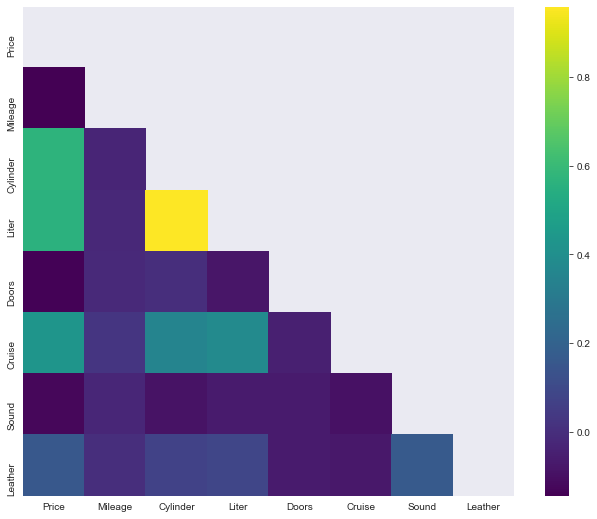

In [6]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax, cmap="viridis");

I'm surprised mileage isn't more correlated with price, so let's check it out below:

### Mileage vs Price

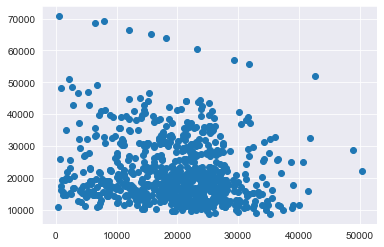

In [7]:
plt.scatter(cars.Mileage, cars.Price);

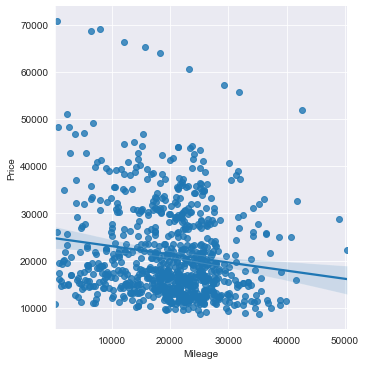

In [8]:
sns.lmplot(data=cars, x='Mileage', y='Price');

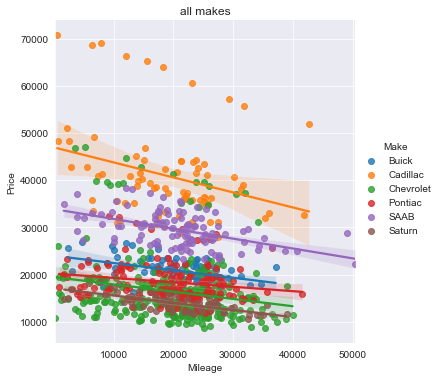

In [9]:
# LM Plot for the entire price vs mileage data

sns.lmplot(data=cars, x='Mileage', y='Price', hue='Make')
plt.title('all makes');

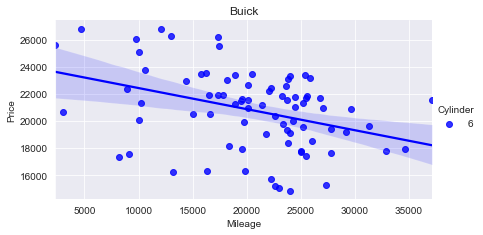

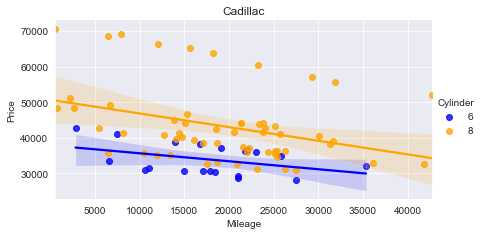

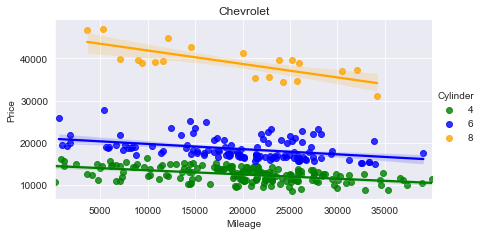

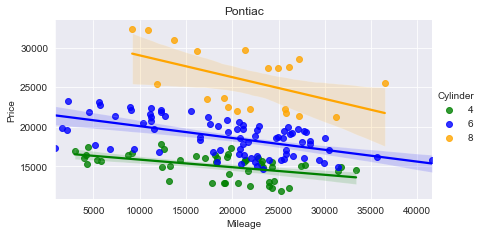

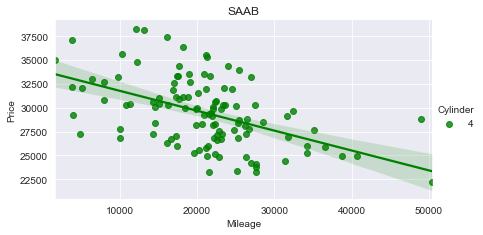

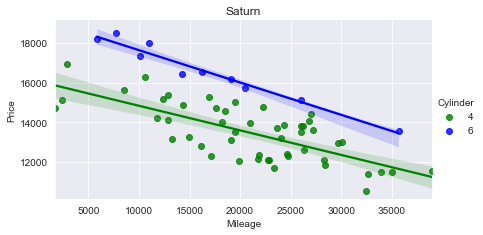

In [10]:
# LM Plot, by make, Milieage vs Price

car_makes = ['Buick', 'Cadillac', 'Chevrolet', 'Pontiac', 'SAAB', 'Saturn']

for car_make in car_makes:
    sns.lmplot(data=cars[cars.Make == car_make], x='Mileage', y='Price', height=3, aspect=2, 
               hue='Cylinder', palette={4:'g', 6:'b', 8:'orange'}) 
    plt.title(car_make);

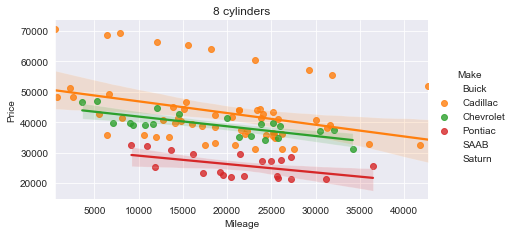

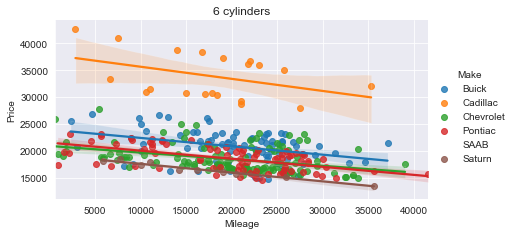

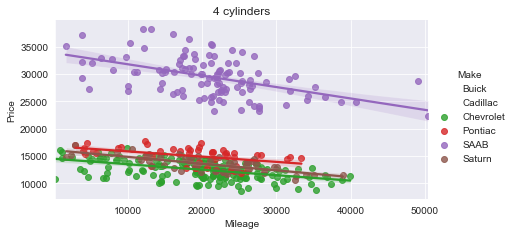

In [11]:
cylinders = [8, 6, 4]

for cylinder in cylinders:
    sns.lmplot(data=cars[cars.Cylinder == cylinder], x='Mileage', y='Price', height=3, aspect=2, hue='Make',
               hue_order=car_makes)
    plt.title(f'{cylinder} cylinders');

So there IS a correlation between mileage and price,

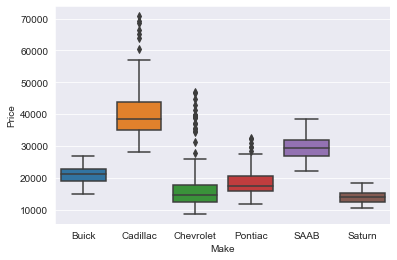

In [12]:
sns.boxplot(data=cars, x='Make', y='Price');

So, cruise and cylinder, both numerical values, have a relatively high positive correlation with price.

Let's look at type (categorical) and doors (numerical) real quick. 

I'm thinking ohe the categoricals, and then scale, and then we can do the linear regression.

Also, do a linear regression individually against features, and then altogether. And compare the difference.

In [13]:
cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [14]:
cars.Trim.value_counts().head()

# discard this feature.

Sedan 4D       170
LS Sedan 4D     50
Coupe 2D        50
LS Coupe 2D     30
LT Sedan 4D     30
Name: Trim, dtype: int64

In [15]:
cars.Type.unique()

array(['Sedan', 'Convertible', 'Hatchback', 'Coupe', 'Wagon'],
      dtype=object)

#### New df with isolated features

In [16]:
carsLinreg_df = cars[['Price', 'Mileage', 'Make', 'Type', 'Cylinder', 'Doors', 'Cruise', 'Leather']]
carsLinreg_df.sample(20)

,Price,Mileage,Make,Type,Cylinder,Doors,Cruise,Leather
626,14398.922693,21688,Pontiac,Wagon,4,4,0,0
602,16106.827221,19465,Pontiac,Wagon,4,4,1,0
333,14194.823604,9561,Chevrolet,Sedan,4,4,0,1
373,16805.057392,19498,Chevrolet,Sedan,6,4,1,0
588,28502.306109,27199,Pontiac,Coupe,8,2,1,1
84,44084.914212,21367,Cadillac,Sedan,8,4,1,1
491,18678.414123,16496,Pontiac,Sedan,6,4,1,0
285,13436.000149,20530,Chevrolet,Sedan,4,4,0,1
795,18490.983029,7755,Saturn,Sedan,6,4,1,1
160,12146.188031,10011,Chevrolet,Hatchback,4,4,0,1


In [17]:
carsLinreg_df.describe()

,Price,Mileage,Cylinder,Doors,Cruise,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.527363,0.752488,0.723881
std,9884.852801,8196.319707,1.387531,0.850169,0.431836,0.447355
min,8638.930895,266.000000,4.000000,2.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,4.000000,1.000000,0.000000
50%,18024.995019,20913.500000,6.000000,4.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,4.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,4.000000,1.000000,1.000000


In [18]:
carsLinreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Type      804 non-null    object 
 4   Cylinder  804 non-null    int64  
 5   Doors     804 non-null    int64  
 6   Cruise    804 non-null    int64  
 7   Leather   804 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 50.4+ KB


## OLS (udemy) vs ols (flatiron)

Looks like the ols (flatiron) one gives a y-intercept. Let's see

- going to use mileage, cylinders and doors

## OLS (udemy)

In [19]:
# define feature and target variables
X = carsLinreg_df[['Mileage', 'Cylinder', 'Doors']]
y = carsLinreg_df[['Price']]

# scale features
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X),
                    index= X.index,
                    columns= X.columns)

HOLY SHIT! When using OLS, we need to add a constant. I kept seeing the .add_constant method all over SOf but didn't know what or why people were adding it. Eventually it dawned on me that this might be the equivalent of the intercept in the ols. I tried it and voila! Now it matches the ols result...

In [20]:
X_ss = sm.add_constant(X_ss)

X_ss.head()

,const,Mileage,Cylinder,Doors
0,1.0,-1.417485,0.52741,0.556279
1,1.0,-1.305902,0.52741,0.556279
2,1.0,-0.810128,0.52741,0.556279
3,1.0,-0.426058,0.52741,0.556279
4,1.0,0.000008,0.52741,0.556279


In [21]:
# linrig
model_OLS = sm.OLS(y, X_ss).fit()
model_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     150.0
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           3.95e-77
Time:                        10:51:38   Log-Likelihood:                -8356.7
No. Observations:                 804   AIC:                         1.672e+04
Df Residuals:                     800   BIC:                         1.674e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.134e+04    279.405     76.388      0.000    2.08e+04    2.19e+04
Mileage    -1272.3412    279.567     -4.551      0.000   -1821.112    -723.571
Cylinder    5587.4472    279.527     19.989      0.000    5038.754    6136.140
Doors      -1404.5513    279.446     -5.026      0.000   -1953.085    -856.018
==============================================================================
Omnibus:                      157.913   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.529
Skew:                           1.278   Prob(JB):                     1.20e-56
Kurtosis:                       4.074   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Predicting price for car with 45k miles, 8 cylinders and 4 doors using the model above.

Start by scaling your multiple feature variables into the same scale used to train the model, then just call est.predict() on the scaled features:

In [29]:
# scaling the values we're trying to predict from against the scaled values of our model above
scaledPredicting = ss.transform([[45000, 8, 4]])

scaledPredicting

array([[3.07256589, 1.96971667, 0.55627894]])

In [30]:
scaledPredicting = sm.add_constant(scaledPredicting,has_constant='add')
scaledPredicting

array([[1.        , 3.07256589, 1.96971667, 0.55627894]])

In [32]:
# predicting based on the scaled values we defined in the previous line above
OLS_prediction = model_OLS.predict(scaledPredicting)

print(OLS_prediction)

[27658.15707316]


## ols (flatiron)

We need to combine the price with the scaled values here in a new dataframe

In [104]:
ols_fsm_df = y.join(X_ss)

ols_fsm_df.head()

,Price,Mileage,Cylinder,Doors
0,17314.103129,-1.417485,0.52741,0.556279
1,17542.036083,-1.305902,0.52741,0.556279
2,16218.847862,-0.810128,0.52741,0.556279
3,16336.913140,-0.426058,0.52741,0.556279
4,16339.170324,0.000008,0.52741,0.556279


In [131]:
f = 'Price ~ Mileage + Cylinder + Doors'

model_ols = ols(formula= f, data= ols_fsm_df).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     150.0
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           3.95e-77
Time:                        08:48:14   Log-Likelihood:                -8356.7
No. Observations:                 804   AIC:                         1.672e+04
Df Residuals:                     800   BIC:                         1.674e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.134e+04    279.405     76.388      0.000    2.08e+04    2.19e+04
Mileage    -1272.3412    279.567     -4.551      0.000   -1821.112    -723.571
Cylinder    5587.4472    279.527     19.989      0.000    5038.754    6136.140
Doors      -1404.5513    279.446     -5.026      0.000   -1953.085    -856.018
==============================================================================
Omnibus:                      157.913   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.529
Skew:                           1.278   Prob(JB):                     1.20e-56
Kurtosis:                       4.074   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Let's make the same prediction from the ols model with the OLS model. Going to use the same params, which we already scaled above.

In [166]:
# let's get the coef from our ols model

model_ols.params

Intercept    21343.143767
Mileage      -1272.341233
Cylinder      5587.447216
Doors        -1404.551343
dtype: float64

In [167]:
# isolating the coefs for mileage, cylinder, doors.
# IMPORTANT: these coefs are based on the scaled values of ea of those features. Not the actual.

model_ols.params[1:4]

Mileage    -1272.341233
Cylinder    5587.447216
Doors      -1404.551343
dtype: float64

In [150]:
#scaled values of 45k, 8 cylinders, and 4 doors

print(scaledPredicting[0])

[3.07256589 1.96971667 0.55627894]


In [173]:
print('ss val of 45k miles= ', scaledPredicting[0][0], 
      '\nmodel coef for miles=', model_ols.params[1])

print('45k miles affect on price:', scaledPredicting[0][0] * model_ols.params[1])

ss val of 45k miles=  3.0725658855625904 
model coef for miles= -1272.3412330664978
45k miles affect on price: -3909.352267514762


In [159]:
eaFeature_pred = model_ols.params[1:4] * scaledPredicting[0]
eaFeature_pred

Mileage     -3909.352268
Cylinder    11005.687899
Doors        -781.322326
dtype: float64

In [164]:
eaFeature_predSum = sum(model_ols.params[1:4] * scaledPredicting[0])
eaFeature_predSum

6315.013305830601

In [160]:
print(eaFeature_pred[0], eaFeature_pred[1], eaFeature_pred[2])
print(eaFeature_pred[0] + eaFeature_pred[1] + eaFeature_pred[2])

-3909.352267514762 11005.68789910673 -781.3223257613676
6315.013305830601


In [165]:
model_ols.params[0] + eaFeature_predSum

27658.157073156442

In [122]:
# turns out I have to feed in a dataframe of scaled values to predict...

pd.DataFrame(scaledPredicting, columns= ['Mileage', 'Cylinder', 'Doors'])

,Mileage,Cylinder,Doors
0,3.072566,1.969717,0.556279


In [175]:
ols_prediction = model_ols.predict(pd.DataFrame(scaledPredicting,
                                              columns= ['Mileage', 'Cylinder', 'Doors']))

ols_prediction

0    27658.157073
dtype: float64

## OHE Make & Type

In [49]:
carsLinreg_df.Make.unique()

array(['Buick', 'Cadillac', 'Chevrolet', 'Pontiac', 'SAAB', 'Saturn'],
      dtype=object)

In [50]:
carsLinreg_df.Type.unique()

array(['Sedan', 'Convertible', 'Hatchback', 'Coupe', 'Wagon'],
      dtype=object)

#### OHE Make- without dropping any cols

I'm going to add this back to the linreg_df and see correlation matrix

In [86]:
ohe = OneHotEncoder()

oheMake = ohe.fit_transform(carsLinreg_df[['Make']])
oheMake.todense()

matrix([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [87]:
ohe.get_feature_names()

array(['x0_Buick', 'x0_Cadillac', 'x0_Chevrolet', 'x0_Pontiac', 'x0_SAAB',
       'x0_Saturn'], dtype=object)

In [88]:
oheMake_df = pd.DataFrame(oheMake.todense(), 
                          index=carsLinreg_df.index, 
                          columns=ohe.get_feature_names(carsLinreg_df[['Make']].columns))

oheMake_df

,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
799,0.0,0.0,0.0,0.0,0.0,1.0
800,0.0,0.0,0.0,0.0,0.0,1.0
801,0.0,0.0,0.0,0.0,0.0,1.0
802,0.0,0.0,0.0,0.0,0.0,1.0
